# 1) Introduction

In this notebook, we will be exploring the impact fans have on the outcome of college basketball games. College basketball atmospheres are known to be rowdy, but how much does that actually help the home team?

The timing of the pandemic makes this an interesting topic to explore. The entirety of the 2019-2020 college basketball regular season was completed without interruption. Fans were allowed to attend games for all of the 2019-2020 regular season. It was only the post-season when issues began.

On the other hand, the entirety of the 2020-2021 regular college basketball season did not allow fans in the stands. This gives us an opportunity to look at how home teams performed with and without fans. By comparing these two seasons, we can see how much the average fanbase impacts the outcome of a home game.

In college sports and in sports in general, there is what’s called “home court advantage.” On average, the home team has an actual advantage due to a number of factors. Some of these factors include the home team being familiar with their own court, the away team being tired from travel, fans supporting the home team, and fans trying to discourage the away team. Fans not being allowed into stadiums for the 2020-2021 season raises some questions: does home court advantage still exist without fans? On average, how much do fans impact college basketball games?

# 2) Hypothesis

**H₀:** There is no significant difference between home court advantage with fans and home court advantage without fans.

**Hₐ:**  There is a significant difference between home court advantage with fans and home court advantage without fans.

# 3) Data

The dataset will be all game results from the 2019-2020 and 2020-2021 regular college basketball seasons.

The data used is from the free version of the sportsdata.io API. The API documentation can be found here: https://sportsdata.io/developers/api-documentation/ncaa-basketball

The specific query that will be looked at is the “Games By Date” query. The endpoint for the query is here: https://api.sportsdata.io/v3/cbb/scores/json/GamesByDate/{date}

The query returns lots of game information, but we will be mostly looking at just the scores of the games.

**It is important to note that the free version of the sportsdata.io API only returns halftime scores and not full game scores. With this in mind, we can still see full game impacts by multiplying the final results by 2.**

In [58]:
# Set up environment

import requests
import pandas as pd
from time import sleep
import math
from scipy import stats
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os

load_dotenv()

True

### Retrieving 2020 (With Fans) Season Data

In [59]:
API_KEY = os.getenv("SPORTSDATAIO_API_KEY")
query = {'key': API_KEY}

with_fans_season = 2020
with_fans_url = f'https://api.sportsdata.io/v3/cbb/scores/json/Games/{with_fans_season}'

with_fans_response = requests.get(with_fans_url, params=query)

In [60]:
with_fans_response.status_code

200

In [61]:
with_fans_response.ok

True

### Retrieving 2021 (No Fans) Season Data

In [62]:
sleep(5)
no_fans_season = 2021
no_fans_url = f'https://api.sportsdata.io/v3/cbb/scores/json/Games/{no_fans_season}'
no_fans_response = requests.get(no_fans_url, params=query)

In [63]:
no_fans_response.ok

True

### Retrieving Team Info

#### We will be retreiving the team info so we can see the conferences of the home and away teams later.

In [64]:
sleep(5)
team_info_url = 'https://api.sportsdata.io/v3/cbb/scores/json/teams'
team_info_response = requests.get(team_info_url, params=query)

In [65]:
team_info_response.ok

True

### Converting JSON Data to Tabular Form

In [66]:
# 2019-2020 Season With Fans

if(with_fans_response.ok):
    with_fans_data = with_fans_response.json()
    with_fans_game_logs = [{
      'season': game['Season'],
      'status': game['Status'],
      'day': game['Day'],
      'date_time': game['DateTime'],
      'away_team': game['AwayTeam'],
      'home_team': game['HomeTeam'],
      'away_team_score': game['AwayTeamScore'],
      'home_team_score': game['HomeTeamScore'],
      'neutral_venue': game['NeutralVenue']
  } for game in with_fans_data]
print(with_fans_game_logs[:5])

[{'season': 2020, 'status': 'Final', 'day': '2019-11-05T00:00:00', 'date_time': '2019-11-05T12:00:00', 'away_team': 'CARK', 'home_team': 'BAYL', 'away_team_score': 29, 'home_team_score': 49, 'neutral_venue': False}, {'season': 2020, 'status': 'Final', 'day': '2019-11-05T00:00:00', 'date_time': '2019-11-05T12:00:00', 'away_team': 'CCT', 'home_team': 'LAMAR', 'away_team_score': 19, 'home_team_score': 40, 'neutral_venue': False}, {'season': 2020, 'status': 'Final', 'day': '2019-11-05T00:00:00', 'date_time': '2019-11-05T13:00:00', 'away_team': 'HOUBAP', 'home_team': 'TULSA', 'away_team_score': 34, 'home_team_score': 38, 'neutral_venue': False}, {'season': 2020, 'status': 'Final', 'day': '2019-11-05T00:00:00', 'date_time': '2019-11-05T17:00:00', 'away_team': 'COLU', 'home_team': 'HOWRD', 'away_team_score': 33, 'home_team_score': 32, 'neutral_venue': False}, {'season': 2020, 'status': 'Final', 'day': '2019-11-05T00:00:00', 'date_time': '2019-11-05T18:00:00', 'away_team': 'PRNCE', 'home_team'

In [67]:
with_fans_df = pd.DataFrame(with_fans_game_logs)

In [68]:
with_fans_df.head(10)

,season,status,day,date_time,away_team,home_team,away_team_score,home_team_score,neutral_venue
0,2020,Final,2019-11-05T00:00:00,2019-11-05T12:00:00,CARK,BAYL,29.0,49.0,False
1,2020,Final,2019-11-05T00:00:00,2019-11-05T12:00:00,CCT,LAMAR,19.0,40.0,False
2,2020,Final,2019-11-05T00:00:00,2019-11-05T13:00:00,HOUBAP,TULSA,34.0,38.0,False
3,2020,Final,2019-11-05T00:00:00,2019-11-05T17:00:00,COLU,HOWRD,33.0,32.0,False
4,2020,Final,2019-11-05T00:00:00,2019-11-05T18:00:00,PRNCE,DUQ,31.0,44.0,False
5,2020,Final,2019-11-05T00:00:00,2019-11-05T18:30:00,LOU,MIA,41.0,35.0,False
6,2020,Final,2019-11-05T00:00:00,2019-11-05T18:30:00,CENT,NWST,27.0,39.0,False
7,2020,Final,2019-11-05T00:00:00,2019-11-05T18:30:00,WAG,SETON,33.0,49.0,False
8,2020,Final,2019-11-05T00:00:00,2019-11-05T19:00:00,DEF,BALLST,20.0,41.0,False
9,2020,Final,2019-11-05T00:00:00,2019-11-05T19:00:00,NEAST,BOSTU,34.0,31.0,False


In [69]:
# 2020-2021 Season Without Fans

if(no_fans_response.ok):
  no_fans_data = no_fans_response.json()
  no_fans_game_logs = [{
      'season': game['Season'],
      'status': game['Status'],
      'day': game['Day'],
      'date_time': game['DateTime'],
      'away_team': game['AwayTeam'],
      'home_team': game['HomeTeam'],
      'away_team_score': game['AwayTeamScore'],
      'home_team_score': game['HomeTeamScore'],
      'neutral_venue': game['NeutralVenue']
  } for game in no_fans_data]
print(no_fans_game_logs[:5])

[{'season': 2021, 'status': 'Canceled', 'day': None, 'date_time': None, 'away_team': 'WEBST', 'home_team': 'PORTST', 'away_team_score': None, 'home_team_score': None, 'neutral_venue': False}, {'season': 2021, 'status': 'Canceled', 'day': '2020-11-01T00:00:00', 'date_time': None, 'away_team': 'NEOM', 'home_team': 'CREIGH', 'away_team_score': None, 'home_team_score': None, 'neutral_venue': False}, {'season': 2021, 'status': 'Canceled', 'day': '2020-11-01T00:00:00', 'date_time': None, 'away_team': 'GB', 'home_team': 'WISC', 'away_team_score': None, 'home_team_score': None, 'neutral_venue': False}, {'season': 2021, 'status': 'Canceled', 'day': '2020-11-05T00:00:00', 'date_time': None, 'away_team': 'MSTM', 'home_team': 'VCU', 'away_team_score': None, 'home_team_score': None, 'neutral_venue': False}, {'season': 2021, 'status': 'Canceled', 'day': '2020-11-08T00:00:00', 'date_time': '2020-11-08T22:00:00', 'away_team': 'UCIRV', 'home_team': 'USC', 'away_team_score': None, 'home_team_score': Non

In [70]:
no_fans_df = pd.DataFrame(no_fans_game_logs)

In [71]:
no_fans_df.head(10)

,season,status,day,date_time,away_team,home_team,away_team_score,home_team_score,neutral_venue
0,2021,Canceled,None,None,WEBST,PORTST,NaN,NaN,False
1,2021,Canceled,2020-11-01T00:00:00,None,NEOM,CREIGH,NaN,NaN,False
2,2021,Canceled,2020-11-01T00:00:00,None,GB,WISC,NaN,NaN,False
3,2021,Canceled,2020-11-05T00:00:00,None,MSTM,VCU,NaN,NaN,False
4,2021,Canceled,2020-11-08T00:00:00,2020-11-08T22:00:00,UCIRV,USC,NaN,NaN,False
5,2021,Canceled,2020-11-25T00:00:00,2020-11-25T00:00:00,PVAM,NW,0.0,0.0,False
6,2021,Canceled,2020-11-25T00:00:00,2020-11-25T00:00:00,CSUFL,SD,0.0,0.0,True
7,2021,Canceled,2020-11-25T00:00:00,2020-11-25T14:00:00,AKRON,MTNST,0.0,0.0,True
8,2021,Canceled,2020-11-25T00:00:00,2020-11-25T16:00:00,MASLOW,TOWS,NaN,NaN,True
9,2021,Postponed,2020-11-25T00:00:00,2020-11-25T16:30:00,FL,MASLOW,NaN,NaN,True


In [72]:
# Team info

if(team_info_response.ok):
    team_info = team_info_response.json()
    all_teams = [{
        'key': team['Key'],
#         'school': team['School'],
#         'name': team['Name'],
        'conference': team['Conference']
  } for team in team_info]
print(all_teams[:5])

[{'key': 'SMU', 'conference': 'American Athletic'}, {'key': 'TEMPL', 'conference': 'American Athletic'}, {'key': 'UCONN', 'conference': 'Big East'}, {'key': 'CIN', 'conference': 'American Athletic'}, {'key': 'TULSA', 'conference': 'American Athletic'}]


In [73]:
all_teams_df = pd.DataFrame(all_teams)

In [74]:
all_teams_df.head()

,key,conference
0,SMU,American Athletic
1,TEMPL,American Athletic
2,UCONN,Big East
3,CIN,American Athletic
4,TULSA,American Athletic


## 4) Methods

As of right now, we have 2019-2020 data stored in the with_fans_df dataframe and the 2020-2021 data stored in the no_fans_df dataframe. The first step will be to clean the data. For each dataframe, this will involve:
- Removing games with neutral venues. These are game locations where both teams need to travel, which we are not interested in.
- Removing any canceled, forfeited, or postponed games
- Removing any null values
- Removing any non-conference games

Removing non-conference games is an important step in eliminating bias. Non-conference games often include "buy" games. In buy games, the away team is essentially paid to travel to a superior's team home court to play. As a result, there are a lot of non-conference games where the home team wins by a very large margin. This would incorrectly influence the data to make home court advantage seem larger than it actually is. 

In an earlier step, we retrieved data that listed each team's conference. We will join that data with the game log dataframes, and then only include games where the home_team conference is equal to the away_team conference. This will get rid of non-conference games.

We will add a new column for each game log dataframe. This column will be the point differential between the home team and the away team. 

We will then check the point differential for each season for normality. If the data is normal, we will then run a t-test for independent samples.

### Cleaning 2019-2020 (With Fans) Data

In [75]:
with_fans_df.head()

,season,status,day,date_time,away_team,home_team,away_team_score,home_team_score,neutral_venue
0,2020,Final,2019-11-05T00:00:00,2019-11-05T12:00:00,CARK,BAYL,29.0,49.0,False
1,2020,Final,2019-11-05T00:00:00,2019-11-05T12:00:00,CCT,LAMAR,19.0,40.0,False
2,2020,Final,2019-11-05T00:00:00,2019-11-05T13:00:00,HOUBAP,TULSA,34.0,38.0,False
3,2020,Final,2019-11-05T00:00:00,2019-11-05T17:00:00,COLU,HOWRD,33.0,32.0,False
4,2020,Final,2019-11-05T00:00:00,2019-11-05T18:00:00,PRNCE,DUQ,31.0,44.0,False


In [76]:
with_fans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5865 entries, 0 to 5864
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   season           5865 non-null   int64  
 1   status           5865 non-null   object 
 2   day              5865 non-null   object 
 3   date_time        5807 non-null   object 
 4   away_team        5865 non-null   object 
 5   home_team        5865 non-null   object 
 6   away_team_score  5782 non-null   float64
 7   home_team_score  5782 non-null   float64
 8   neutral_venue    5765 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 412.5+ KB


In [77]:
with_fans_df['status'].unique()

array(['Final', 'Canceled', 'Postponed'], dtype=object)

In [78]:
# clear out postponed and canceled games
with_fans_final_df = with_fans_df[with_fans_df['status'] == 'Final']

In [79]:
# clear out neutral-court games
with_fans_no_neutral_df = with_fans_final_df[with_fans_final_df['neutral_venue'] == False]

In [80]:
with_fans_no_neutral_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5231 entries, 0 to 5787
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   season           5231 non-null   int64  
 1   status           5231 non-null   object 
 2   day              5231 non-null   object 
 3   date_time        5231 non-null   object 
 4   away_team        5231 non-null   object 
 5   home_team        5231 non-null   object 
 6   away_team_score  5230 non-null   float64
 7   home_team_score  5230 non-null   float64
 8   neutral_venue    5231 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 408.7+ KB


In [81]:
# clear out null values
with_fans_clean_df = with_fans_no_neutral_df[with_fans_no_neutral_df['away_team_score'].notnull()]

In [82]:
with_fans_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5230 entries, 0 to 5787
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   season           5230 non-null   int64  
 1   status           5230 non-null   object 
 2   day              5230 non-null   object 
 3   date_time        5230 non-null   object 
 4   away_team        5230 non-null   object 
 5   home_team        5230 non-null   object 
 6   away_team_score  5230 non-null   float64
 7   home_team_score  5230 non-null   float64
 8   neutral_venue    5230 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 408.6+ KB


In [83]:
with_fans_clean_df.head()

,season,status,day,date_time,away_team,home_team,away_team_score,home_team_score,neutral_venue
0,2020,Final,2019-11-05T00:00:00,2019-11-05T12:00:00,CARK,BAYL,29.0,49.0,False
1,2020,Final,2019-11-05T00:00:00,2019-11-05T12:00:00,CCT,LAMAR,19.0,40.0,False
2,2020,Final,2019-11-05T00:00:00,2019-11-05T13:00:00,HOUBAP,TULSA,34.0,38.0,False
3,2020,Final,2019-11-05T00:00:00,2019-11-05T17:00:00,COLU,HOWRD,33.0,32.0,False
4,2020,Final,2019-11-05T00:00:00,2019-11-05T18:00:00,PRNCE,DUQ,31.0,44.0,False


In [84]:
# cleaning the dataframe to get rid of non-conference games
home_team_conf = pd.merge(left=with_fans_clean_df, right=all_teams_df, how='inner', left_on='home_team', right_on='key')
away_team_conf = pd.merge(left=home_team_conf, right=all_teams_df, how='inner', left_on='away_team', right_on='key')
away_team_conf.head()

with_fans_conf_df = away_team_conf[away_team_conf['conference_x'] == away_team_conf['conference_y']]

with_fans_conf_df.head()

,season,status,day,date_time,away_team,home_team,away_team_score,home_team_score,neutral_venue,key_x,conference_x,key_y,conference_y
19,2020,Final,2020-02-06T00:00:00,2020-02-06T19:00:00,TXST,COAST,47.0,30.0,False,COAST,Sun Belt,TXST,Sun Belt
20,2020,Final,2020-01-16T00:00:00,2020-01-16T20:00:00,TXST,LAMON,30.0,30.0,False,LAMON,Sun Belt,TXST,Sun Belt
21,2020,Final,2020-01-18T00:00:00,2020-01-18T20:00:00,TXST,LOULAF,32.0,28.0,False,LOULAF,Sun Belt,TXST,Sun Belt
23,2020,Final,2019-12-21T00:00:00,2019-12-21T13:00:00,TXST,GAST,32.0,38.0,False,GAST,Sun Belt,TXST,Sun Belt
24,2020,Final,2020-01-04T00:00:00,2020-01-04T15:00:00,TXST,ARKST,33.0,31.0,False,ARKST,Sun Belt,TXST,Sun Belt


### Cleaning 2020-2021 (Without Fans) Data

In [85]:
no_fans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6248 entries, 0 to 6247
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   season           6248 non-null   int64  
 1   status           6248 non-null   object 
 2   day              6247 non-null   object 
 3   date_time        5873 non-null   object 
 4   away_team        6248 non-null   object 
 5   home_team        6248 non-null   object 
 6   away_team_score  5177 non-null   float64
 7   home_team_score  5178 non-null   float64
 8   neutral_venue    6248 non-null   bool   
dtypes: bool(1), float64(2), int64(1), object(5)
memory usage: 396.7+ KB


In [86]:
no_fans_df['status'].unique()

array(['Canceled', 'Postponed', 'Final', 'F/OT', 'Forfeit'], dtype=object)

In [87]:
# clear out postponed and canceled games
no_fans_final_df = no_fans_df[no_fans_df['status'].isin(['Final', 'F/OT'])]

In [88]:
no_fans_final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4117 entries, 13 to 6247
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   season           4117 non-null   int64  
 1   status           4117 non-null   object 
 2   day              4117 non-null   object 
 3   date_time        4117 non-null   object 
 4   away_team        4117 non-null   object 
 5   home_team        4117 non-null   object 
 6   away_team_score  4117 non-null   float64
 7   home_team_score  4117 non-null   float64
 8   neutral_venue    4117 non-null   bool   
dtypes: bool(1), float64(2), int64(1), object(5)
memory usage: 293.5+ KB


In [89]:
# clear out neutral-court games
no_fans_clean_df = no_fans_final_df[no_fans_final_df['neutral_venue'] == False]

In [90]:
no_fans_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3723 entries, 13 to 6227
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   season           3723 non-null   int64  
 1   status           3723 non-null   object 
 2   day              3723 non-null   object 
 3   date_time        3723 non-null   object 
 4   away_team        3723 non-null   object 
 5   home_team        3723 non-null   object 
 6   away_team_score  3723 non-null   float64
 7   home_team_score  3723 non-null   float64
 8   neutral_venue    3723 non-null   bool   
dtypes: bool(1), float64(2), int64(1), object(5)
memory usage: 265.4+ KB


In [91]:
# cleaning the dataframe to get rid of non-conference games
nf_home_team_conf = pd.merge(left=no_fans_clean_df, right=all_teams_df, how='inner', left_on='home_team', right_on='key')
nf_away_team_conf = pd.merge(left=nf_home_team_conf, right=all_teams_df, how='inner', left_on='away_team', right_on='key')
nf_away_team_conf.head()

no_fans_conf_df = nf_away_team_conf[nf_away_team_conf['conference_x'] == nf_away_team_conf['conference_y']]

no_fans_conf_df.head(10)

,season,status,day,date_time,away_team,home_team,away_team_score,home_team_score,neutral_venue,key_x,conference_x,key_y,conference_y
18,2021,Final,2021-02-12T00:00:00,2021-02-12T21:00:00,FLINT,UTEP,21.0,27.0,False,UTEP,Conference USA,FLINT,Conference USA
19,2021,Final,2021-02-13T00:00:00,2021-02-13T21:00:00,FLINT,UTEP,24.0,27.0,False,UTEP,Conference USA,FLINT,Conference USA
20,2021,Final,2021-01-29T00:00:00,2021-01-29T18:00:00,FLINT,CHARLT,20.0,22.0,False,CHARLT,Conference USA,FLINT,Conference USA
21,2021,Final,2021-01-30T00:00:00,2021-01-30T16:00:00,FLINT,CHARLT,23.0,24.0,False,CHARLT,Conference USA,FLINT,Conference USA
22,2021,Final,2021-01-08T00:00:00,2021-01-08T19:00:00,FLINT,MTNST,24.0,20.0,False,MTNST,Conference USA,FLINT,Conference USA
23,2021,Final,2021-01-09T00:00:00,2021-01-09T17:00:00,FLINT,MTNST,20.0,24.0,False,MTNST,Conference USA,FLINT,Conference USA
24,2021,Final,2021-01-16T00:00:00,2021-01-16T16:00:00,FLINT,FLATL,22.0,38.0,False,FLATL,Conference USA,FLINT,Conference USA
25,2021,Final,2021-02-28T00:00:00,2021-02-28T15:00:00,FLINT,WKENT,21.0,32.0,False,WKENT,Conference USA,FLINT,Conference USA
26,2021,Final,2021-03-01T00:00:00,2021-03-01T13:00:00,FLINT,WKENT,21.0,25.0,False,WKENT,Conference USA,FLINT,Conference USA
31,2021,Final,2021-02-11T00:00:00,2021-02-11T18:00:00,GAS,GAST,27.0,28.0,False,GAST,Sun Belt,GAS,Sun Belt


### Calculating Win/Loss Differential For Both DataFrames

In [92]:
with_fans_conf_df['pt_diff'] = with_fans_conf_df['home_team_score'] - with_fans_conf_df['away_team_score']
no_fans_conf_df['pt_diff'] = no_fans_conf_df['home_team_score'] - no_fans_conf_df['away_team_score']

C:\Users\mattd\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\mattd\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [93]:
with_fans_conf_df.head()

,season,status,day,date_time,away_team,home_team,away_team_score,home_team_score,neutral_venue,key_x,conference_x,key_y,conference_y,pt_diff
19,2020,Final,2020-02-06T00:00:00,2020-02-06T19:00:00,TXST,COAST,47.0,30.0,False,COAST,Sun Belt,TXST,Sun Belt,-17.0
20,2020,Final,2020-01-16T00:00:00,2020-01-16T20:00:00,TXST,LAMON,30.0,30.0,False,LAMON,Sun Belt,TXST,Sun Belt,0.0
21,2020,Final,2020-01-18T00:00:00,2020-01-18T20:00:00,TXST,LOULAF,32.0,28.0,False,LOULAF,Sun Belt,TXST,Sun Belt,-4.0
23,2020,Final,2019-12-21T00:00:00,2019-12-21T13:00:00,TXST,GAST,32.0,38.0,False,GAST,Sun Belt,TXST,Sun Belt,6.0
24,2020,Final,2020-01-04T00:00:00,2020-01-04T15:00:00,TXST,ARKST,33.0,31.0,False,ARKST,Sun Belt,TXST,Sun Belt,-2.0


In [94]:
no_fans_conf_df.head()

,season,status,day,date_time,away_team,home_team,away_team_score,home_team_score,neutral_venue,key_x,conference_x,key_y,conference_y,pt_diff
18,2021,Final,2021-02-12T00:00:00,2021-02-12T21:00:00,FLINT,UTEP,21.0,27.0,False,UTEP,Conference USA,FLINT,Conference USA,6.0
19,2021,Final,2021-02-13T00:00:00,2021-02-13T21:00:00,FLINT,UTEP,24.0,27.0,False,UTEP,Conference USA,FLINT,Conference USA,3.0
20,2021,Final,2021-01-29T00:00:00,2021-01-29T18:00:00,FLINT,CHARLT,20.0,22.0,False,CHARLT,Conference USA,FLINT,Conference USA,2.0
21,2021,Final,2021-01-30T00:00:00,2021-01-30T16:00:00,FLINT,CHARLT,23.0,24.0,False,CHARLT,Conference USA,FLINT,Conference USA,1.0
22,2021,Final,2021-01-08T00:00:00,2021-01-08T19:00:00,FLINT,MTNST,24.0,20.0,False,MTNST,Conference USA,FLINT,Conference USA,-4.0


### Analyzing Data

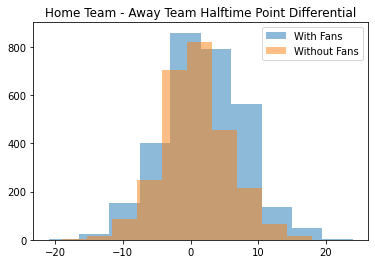

In [95]:
plt.hist(with_fans_conf_df['pt_diff'], alpha = 0.5)
plt.hist(no_fans_conf_df['pt_diff'], alpha = 0.5)
plt.legend(['With Fans','Without Fans'])
plt.title('Home Team - Away Team Halftime Point Differential')
plt.show()

In [96]:
print(stats.describe(with_fans_conf_df['pt_diff']))
print(stats.describe(no_fans_conf_df['pt_diff']))

DescribeResult(nobs=2990, minmax=(-21.0, 24.0), mean=1.5933110367892978, variance=35.78503386441478, skewness=-0.015682450348121275, kurtosis=0.16291204677858362)
DescribeResult(nobs=2638, minmax=(-19.0, 18.0), mean=0.866565579984837, variance=24.359132000058654, skewness=0.034866705863179755, kurtosis=0.46525972782342206)


In [97]:
# both data sets appear normal. can conduct t-test
stats.ttest_ind(with_fans_conf_df['pt_diff'], no_fans_conf_df['pt_diff'])

Ttest_indResult(statistic=4.9320866440682165, pvalue=8.369464888670374e-07)

In [98]:
def get_95_ci(array_1, array_2):
    sample_1_n = array_1.shape[0]
    sample_2_n = array_2.shape[0]
    sample_1_mean = array_1.mean()
    sample_2_mean = array_2.mean()
    sample_1_var = array_1.var()
    sample_2_var = array_2.var()
    mean_difference = sample_2_mean - sample_1_mean
    std_err_difference = math.sqrt((sample_1_var/sample_1_n)+(sample_2_var/sample_2_n))
    margin_of_error = 1.96 * std_err_difference
    ci_lower = mean_difference - margin_of_error
    ci_upper = mean_difference + margin_of_error
    return("The difference in means at the 95% confidence interval (two-tail) is between "+str(ci_lower)+" and "+str(ci_upper)+".")

print(get_95_ci(with_fans_conf_df['pt_diff'], no_fans_conf_df['pt_diff']))

The difference in means at the 95% confidence interval (two-tail) is between -1.0121404241458403 and -0.4413504894630813.


In [99]:
print(no_fans_conf_df['pt_diff'].mean())

0.866565579984837


In [100]:
# extrapolating halftime day to full game data
print(stats.describe(with_fans_conf_df['pt_diff']*2))
print(stats.describe(no_fans_conf_df['pt_diff']*2))

DescribeResult(nobs=2990, minmax=(-42.0, 48.0), mean=3.1866220735785955, variance=143.1401354576591, skewness=-0.015682450348121275, kurtosis=0.16291204677858362)
DescribeResult(nobs=2638, minmax=(-38.0, 36.0), mean=1.733131159969674, variance=97.43652800023462, skewness=0.034866705863179755, kurtosis=0.46525972782342206)


## 5) Results

The home-away team point differential distributions for both seasons are both comfortably normally distributed. Knowing this, we were able to conduct a t-test. We found that there is a significant difference between home court advantage with and without fans in the stands. We can reject the null hypothesis that there is no significant difference between home court advantage with fans and home court advantage without fans.

As a reminder, the data we used was the score of games at halftime instead of the score at the end of games. The 95% confidence interval suggests that, per half of basketball played, the home - away team point differential between games with fans and without fans is between -1.01 and -0.44.

When multiplying the results by two, we can see full game impacts instead of half-game impacts. Currently, on average, home games with fans give the home team a 3.19 point advantage. On average, home games without fans give the home team a 1.73 point advantage.

# 6) Discussion and recommendation

Fans do make an impact! As a fan of the sport, this is happy news. It continues to make sense to be rowdy in the stands.

On the coaching side, this is also good knowledge to have. During the non-conference part of the season, there are occasions where a stadium may be close to empty. Games taking place near big holidays tend to have much smaller crowds due to students going home. If a coach is looking for an opportunity to get a big win at an opposing team's court, attempting to schedule it when fans aren't around would be a good move.